# Catalyst BO Debug Notebook

This notebook breaks the *bo_closed_loop.py* script into digestible cells so you can
run, inspect, and tweak each part individually.  Start by executing the first
code cell to import dependencies and set global constants, then proceed
sequentially.

In [2]:

import math, re, datetime as _dt
from pathlib import Path
from typing import List, Sequence

import numpy as np
import pandas as pd
import torch, gpytorch
from torch.quasirandom import SobolEngine

# Chemical‑space constants
METALS = ("Fe", "In", "Ce", "Co", "Cu", "Zn")
PROMOTER = "K"
SUPPORTS = ("SiO2", "Al2O3", "TiO2", "ZrO2")

OBJ_SIGNS = {"cost": -1, "ch4_sel": -1, "co2_conv": +1, "meoh_sel": +1}

_UPPER_METAL = 5.0      # wt‑%
_UPPER_PROMOTER = 1.0   # wt‑%

def _log(msg: str) -> None:
    ts = _dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f'[{ts}] {msg}')


/home/ws/gt5111/mambaforge/envs/bo_ikft/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

class CatalystBO:
    """
    Closed‑loop Bayesian optimiser with hard feasibility constraints.
    """

    _LOADING_RE = re.compile(
        r"^(Fe|In|Ce|Co|Cu|Zn|K)\s*(?:Loading)?\s*\(?\s*wt\s*%?\s*\)?$", re.I
    )
    _OBJ_PATTERNS = {
        "cost": re.compile(r"cost", re.I),
        "ch4_sel": re.compile(r"ch4.*sel", re.I),
        "co2_conv": re.compile(r"co2.*conv", re.I),
        "meoh_sel": re.compile(r"meoh.*sel", re.I),
    }

    def __init__(self, csv_path="BO-Data.csv", device=None, drop_objectives=None):
        self.csv_path = Path(csv_path)
        if not self.csv_path.exists():
            raise FileNotFoundError(self.csv_path)

        self.device = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        ) if device is None else device
        if self.device.type == "cpu":
            _log("CUDA unavailable – running on CPU.")

        self._drop_obj = set(drop_objectives or [])
        self.support_cols = [f"sup_{s}" for s in SUPPORTS]

        # Load & prepare data
        self.history = self._load_and_prepare_csv()
        self._detect_columns()
        self._build_bounds()
        self.kpi_min: Dict[str, float] = {}
        self.kpi_max: Dict[str, float] = {}
        self._update_merit()

        _log(
            f"Loaded {len(self.history)} rows | inputs={self.loading_cols} | "
            f"target='Merit' ({len(self.objective_cols)} raw KPIs)."
        )

        self.model = None
        self.likelihood = None

    # ---------------- CSV helpers ----------------
    def _load_and_prepare_csv(self):
        df = (
            pd.read_csv(self.csv_path, low_memory=False)
            .rename(columns=lambda c: c.strip())
            .fillna({"Support": ""})
        )
        if "Support" not in df.columns:
            raise ValueError("CSV lacks a 'Support' column.")
        df["Support"] = df["Support"].astype(str).str.strip()
        for sup in SUPPORTS:
            df[f"sup_{sup}"] = (df["Support"] == sup).astype(float)
        return df.apply(lambda c: pd.to_numeric(c, errors="ignore")).reset_index(drop=True)

    def _detect_columns(self):
        # Loading columns
        load_cols = [c for c in self.history.columns if self._LOADING_RE.match(c)]
        expected = set((*METALS, PROMOTER))
        present = {
            next((s for s in expected if re.search(rf"\b{s}\b", c, re.I)), None)
            for c in load_cols
        }
        missing = expected.difference(present)
        for sym in missing:
            cand = [c for c in self.history.columns if re.search(rf"\b{sym}\b", c, re.I) and "wt" in c.lower()]
            if not cand:
                raise ValueError(f"Missing loading column for element '{sym}'.")
            load_cols.append(cand[0])

        order = {m: i for i, m in enumerate((*METALS, PROMOTER))}
        load_cols.sort(key=lambda c: order[next(s for s in order if re.search(rf"\b{s}\b", c, re.I))])
        self.loading_cols = load_cols + self.support_cols

        # KPI columns
        raw_cols = []
        for name, pat in self._OBJ_PATTERNS.items():
            match = [c for c in self.history.columns if pat.search(c)]
            if not match:
                raise ValueError(f"Objective column matching '{name}' not found.")
            raw_cols.append(match[0])
        self.raw_objective_cols = raw_cols
        self.objective_cols = [c for c in raw_cols if c.split()[0].lower() not in self._drop_obj]
        if not self.objective_cols:
            raise ValueError("No KPI remains to build Merit after drops.")

        num_cols = self.loading_cols + self.objective_cols
        self.history[num_cols] = self.history[num_cols].apply(pd.to_numeric, errors="coerce")
        self.history.dropna(subset=num_cols, inplace=True)
    
    # ---------------- Merit ----------------
    def _update_merit(self):
        df = self.history
        parts = []
        for col in self.objective_cols:
            self.kpi_min[col] = self.history[col].min()
            self.kpi_max[col] = self.history[col].max()
            key = next(k for k, v in self._OBJ_PATTERNS.items() if v.search(col))
            sign = OBJ_SIGNS[key]
            cmin, cmax = df[col].min(), df[col].max()
            scaled = np.zeros_like(df[col], float) if math.isclose(cmin, cmax) else (df[col] - cmin) / (cmax - cmin)
            if sign < 0:
                scaled = 1.0 - scaled
            parts.append(scaled)
        df["Merit"] = np.clip(np.vstack(parts).mean(axis=0), 0.0, 1.0)

    # ---------------- GP helpers ----------------
    def _prepare_tensors(self):
        X = torch.tensor(self.history[self.loading_cols].values, dtype=torch.double, device=self.device)
        y = torch.tensor(self.history["Merit"].values, dtype=torch.double, device=self.device)
        return X, y

    def _build_bounds(self):
        ub = []
        for col in self.loading_cols:
            if col.startswith("sup_"):
                ub.append(1.0)
            elif PROMOTER in col:
                ub.append(_UPPER_PROMOTER)
            else:
                ub.append(_UPPER_METAL)
        self._upper_bounds = torch.tensor(ub, dtype=torch.double, device=self.device)

    def fit_merit_gp(self, training_iter=750):
        X, y = self._prepare_tensors()
        likelihood = gpytorch.likelihoods.GaussianLikelihood().to(self.device)

        class ExactGP(gpytorch.models.ExactGP):
            def __init__(self, tx, ty, lik):
                super().__init__(tx, ty, lik)
                self.mean_module = gpytorch.means.ConstantMean()
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

            def forward(self, x):
                return gpytorch.distributions.MultivariateNormal(self.mean_module(x), self.covar_module(x))

        model = ExactGP(X, y, likelihood).double().to(self.device)
        opt = torch.optim.Adam(model.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        _log("Fitting GP surrogate …")
        model.train(); likelihood.train()
        for _ in range(training_iter):
            opt.zero_grad()
            loss = -mll(model(X), y)
            loss.backward(); opt.step()
        model.eval(); likelihood.eval()
        self.model, self.likelihood = model, likelihood
        _log("GP surrogate ready.")


    # ------------------------------------------------------------------
    # KPI surrogate models (one Exact GP per raw objective)
    # ------------------------------------------------------------------
    def _train_kpi_models(self, training_iter: int = 500):
        """Fit an independent GP for every KPI so we can simulate 4-D outputs."""
        self.kpi_models = {}
        X, _ = self._prepare_tensors()              # X works for every KPI

        for col in self.objective_cols:

            # # -------- 1. choose target transformation --------------------------
            # raw_vals = self.history[col].values
            # if "cost" in col.lower():              # log-transform Cost
            #     vals = np.log1p(raw_vals)          # log(1 + $/kg)
            # elif any(key in col.lower() for key in ("ch4", "meoh")):   # logit for selectivities
            #     pct = np.clip(raw_vals, 1e-3, 99.999)                  # avoid 0/100 → inf
            #     vals = np.log(pct / (100.0 - pct))                     # logit(p/100)
            # else:                                   # CO₂ conversion stays linear %
            #     vals = raw_vals

            # y = torch.tensor(vals, dtype=torch.double, device=self.device)

            # # -------- 2. pick kernel -------------------------------------------
            # if "cost" in col.lower() or "sel" in col.lower():
            #     base_k = gpytorch.kernels.MaternKernel(nu=1.5)         # sharper changes
            # else:
            #     base_k = gpytorch.kernels.RBFKernel()

            # lik = gpytorch.likelihoods.GaussianLikelihood().to(self.device)

                    # -------- 1. choose target transformation --------------------------
            raw_vals = self.history[col].values
            if "cost" in col.lower():                         # log–Cost
                vals = np.log1p(raw_vals)

            elif any(key in col.lower() for key in ("ch4", "meoh")):   # logit for selectivities
                pct  = np.clip(raw_vals, 1e-3, 99.999)        # avoid 0/100 → inf
                vals = np.log(pct / (100.0 - pct))            # logit(p/100)

            else:                                             # CO₂ conversion linear %
                vals = raw_vals

            y = torch.tensor(vals, dtype=torch.double, device=self.device)

            # -------- 2. pick kernel -------------------------------------------
            if "cost" in col.lower() or "sel" in col.lower():
                # sharper Matérn and ARD for selectivities & cost
                base_k = gpytorch.kernels.MaternKernel(
                    nu=1.5, ard_num_dims=X.shape[1]
                )
                base_k.lengthscale = 1.0        # start shorter
            else:
                base_k = gpytorch.kernels.RBFKernel()

            lik = gpytorch.likelihoods.GaussianLikelihood().to(self.device)


            class KPI_GP(gpytorch.models.ExactGP):
                def __init__(self, tx, ty, lik):
                    super().__init__(tx, ty, lik)
                    self.mean_module  = gpytorch.means.ConstantMean()
                    self.covar_module = gpytorch.kernels.ScaleKernel(base_k)

                def forward(self, x):
                    return gpytorch.distributions.MultivariateNormal(
                        self.mean_module(x), self.covar_module(x)
                    )

            # -------- 3. train GP (unchanged) ----------------------------------
            m = KPI_GP(X, y, lik).double().to(self.device)
            opt = torch.optim.Adam(m.parameters(), lr=0.1)
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(lik, m)

            m.train(); lik.train()
            for _ in range(training_iter):
                opt.zero_grad(); loss = -mll(m(X), y); loss.backward(); opt.step()
            m.eval(); lik.eval()

            self.kpi_models[col] = (m, lik)


    # ---------------- Feasibility + acquisition ----------------
    def _feasibility_mask(self, cand: np.ndarray) -> np.ndarray:
        idx = {c: i for i, c in enumerate(self.loading_cols)}
        metal_idx = [idx[c] for c in self.loading_cols if any(m in c for m in METALS)]
        prom_idx = idx[next(c for c in self.loading_cols if PROMOTER in c and "Loading" in c)]
        sup_idx = [idx[c] for c in self.support_cols]

        metals = cand[:, metal_idx]
        promoter = cand[:, prom_idx]
        support = cand[:, sup_idx]

        n_metals = (metals > 1e-8).sum(axis=1)
        tot_load = metals.sum(axis=1) + promoter

        return (
            (n_metals <= 3)
            & (tot_load >= 2.5)
            & (tot_load <= 5.0)
            & (promoter <= _UPPER_PROMOTER + 1e-9)
            & np.isclose(support.sum(axis=1), 1.0)
        )

    def _sample_candidates(self, n):
        dim = len(self.loading_cols)
        out = torch.zeros((n, dim), dtype=torch.double, device=self.device)

        metal_cols = [i for i, c in enumerate(self.loading_cols) if any(m in c for m in METALS)]
        prom_col  = next(i for i, c in enumerate(self.loading_cols) if PROMOTER in c and "Loading" in c)
        sup_cols  = [self.loading_cols.index(c) for c in self.support_cols]

        for i in range(n):
            k = torch.randint(1, 4, (1,), device=self.device).item()          # 1-3 active metals
            chosen = torch.randperm(len(metal_cols), device=self.device)[:k]

            # Dirichlet draw in double precision
            vec = (
                torch.distributions
                    .Dirichlet(torch.ones(k, dtype=torch.double, device=self.device))
                    .sample()
            )
            scale = torch.rand(1, dtype=torch.double, device=self.device) * 2.5 + 2.5  # → [2.5, 5]
            out[i, [metal_cols[j] for j in chosen]] = vec * scale

            # promoter (double)
            out[i, prom_col] = torch.rand((), dtype=torch.double, device=self.device) * _UPPER_PROMOTER

            # one-hot support (double)
            sup = torch.randint(0, len(SUPPORTS), (1,), device=self.device).item()
            out[i, sup_cols[sup]] = 1.0

        return out
    
    
    # ------------------------------------------------------------------
    # Simulate KPI values for a batch and append to history
    # ------------------------------------------------------------------
    def _simulate_and_append(self, new_pts: pd.DataFrame, gen: int, noise_sd: float = 0.02):
        """
        Parameters
        ----------
        new_pts : DataFrame
            The design-variable columns returned by `suggest_next_batch`.
        gen : int
            The generation index supplied by the campaign loop.
        noise_sd : float
            Std-dev of Gaussian noise added to each KPI draw.

        Workflow
        --------
        1. Draw one posterior sample for every KPI GP at the batch inputs.
        2. Write those values into *new_pts* (four new columns).
        3. Tag the rows with `Generation = gen`.
        4. Append to self.history, then recompute Merit with updated KPI
           min/max.  Finally, invalidate the Merit GP so it will retrain
           automatically on the next `suggest_next_batch` call.
        """
        # safety: make sure KPI GPs are trained
        if not getattr(self, "kpi_models", None):
            raise RuntimeError("Call _train_kpi_models() before simulating.")

        # ---- 1. sample KPIs ----------------------------------------------
        X_new = torch.tensor(
            new_pts[self.loading_cols].values, dtype=torch.double, device=self.device
        )

        new_pts = new_pts.copy()          # avoid mutating caller’s frame
        for col, (model, lik) in self.kpi_models.items():
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                mu = lik(model(X_new)).mean.cpu().numpy()

            if "cost" in col.lower():
                sims = np.expm1(mu)                        # back-transform Cost
            elif any(key in col.lower() for key in ("ch4", "meoh")):
                sims = 100 / (1.0 + np.exp(-mu))           # inverse logit → %
            else:
                sims = mu                                  # CO₂ conversion unchanged

            #new_pts[col] = sims + np.random.normal(0.0, noise_sd, size=len(mu))

            if "cost" in col.lower():
                sims = np.expm1(mu)                         # back-transform Cost

            elif any(key in col.lower() for key in ("ch4", "meoh")):
                sims = 100.0 / (1.0 + np.exp(-mu))          # inverse-logit → %

            else:  # CO₂ conversion stays linear
                sims = mu

            new_pts[col] = sims + np.random.normal(0.0, noise_sd, size=len(mu))

        # ---- 2. generation label -----------------------------------------
        new_pts["Generation"] = gen

        # ---- 3. append & recompute Merit ---------------------------------
        self.history = pd.concat([self.history, new_pts], ignore_index=True)
        self._update_merit()              # dynamic rescaling

        # clear Merit GP so suggest_next_batch retrains on enlarged history
        self.model = None


    def suggest_next_batch(self, batch_size=24, draw_size=2048, max_tries=8):
        if self.model is None:
            self.fit_surrogate()

        for attempt in range(max_tries):
            draws = self._sample_candidates(draw_size)
            feas_mask = self._feasibility_mask(draws.cpu().numpy())
            feas = draws[feas_mask]
            if feas.size(0) >= batch_size:
                break
            draw_size *= 2                # double pool and try again
        else:
            raise RuntimeError("Still couldn't get enough feasible points – check constraints.")

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            post = self.likelihood(self.model(feas))
            mu, var = post.mean, post.variance.clamp_min(1e-12)

        best = torch.tensor(self.history["Merit"].values, device=self.device).max()
        improv = mu - best
        sigma = var.sqrt()
        z = improv / sigma
        sqrt2 = math.sqrt(2.0)
        ei = improv * 0.5 * (1 + torch.erf(z / sqrt2)) + sigma * torch.exp(-0.5 * z ** 2) / math.sqrt(2 * math.pi)

        top = torch.topk(ei, batch_size).indices
        return feas[top].cpu().numpy()

    # ------------------------------------------------------------------
    # Backward-compat alias (old notebooks call fit_surrogate)
    # ------------------------------------------------------------------
    def fit_surrogate(self, *a, **kw):
        """Alias for fit_merit_gp – kept for older code paths."""
        return self.fit_merit_gp(*a, **kw)


In [4]:
# ----------------------------------------------------------------------------------
# 5-generation closed-loop campaign
# ----------------------------------------------------------------------------------
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np, pandas as pd

n_gen, batch_size = 5, 24
csv_out_dir = Path("bo_outputs"); csv_out_dir.mkdir(exist_ok=True)

bo = CatalystBO("BO-Data.csv")
bo._train_kpi_models()              # fit KPI models on initial data

best_merit = []

for g in range(1, n_gen + 1):
    print(f"\n=== Generation {g} ===")
    raw = bo.suggest_next_batch(batch_size=batch_size)
    df  = pd.DataFrame(raw, columns=bo.loading_cols)
    df.insert(0, "Support",
              [SUPPORTS[int(np.argmax(df[bo.support_cols].iloc[i].values))]
               for i in range(len(df))])

    fname = csv_out_dir / f"gen{g:02d}_suggestions.csv"
    df.to_csv(fname, index=False);  print(" → saved", fname)

    bo._simulate_and_append(df, gen=g)     # adds 4 KPIs + Merit
    bo._train_kpi_models(1000)       # quick re-fit for next gen
    best_merit.append(bo.history["Merit"].max())

/home/ws/gt5111/mambaforge/envs/bo_ikft/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/tmp/ipykernel_8250/1713695146.py:58: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(lambda c: pd.to_numeric(c, errors="ignore")).reset_index(drop=True)


[2025-07-15 09:33:25] CUDA unavailable – running on CPU.
[2025-07-15 09:33:25] Loaded 120 rows | inputs=['Fe Loading [wt%]', 'In Loading [wt%]', 'Ce Loading [wt%]', 'Co Loading [wt%]', 'Cu Loading [wt%]', 'Zn Loading [wt%]', 'K Loading [wt%]', 'sup_SiO2', 'sup_Al2O3', 'sup_TiO2', 'sup_ZrO2'] | target='Merit' (4 raw KPIs).

=== Generation 1 ===
[2025-07-15 09:33:41] Fitting GP surrogate …
[2025-07-15 09:33:45] GP surrogate ready.
 → saved bo_outputs/gen01_suggestions.csv

=== Generation 2 ===
[2025-07-15 09:35:22] Fitting GP surrogate …
[2025-07-15 09:35:39] GP surrogate ready.
 → saved bo_outputs/gen02_suggestions.csv

=== Generation 3 ===
[2025-07-15 09:36:58] Fitting GP surrogate …
[2025-07-15 09:37:10] GP surrogate ready.
 → saved bo_outputs/gen03_suggestions.csv

=== Generation 4 ===
[2025-07-15 09:39:57] Fitting GP surrogate …
[2025-07-15 09:40:20] GP surrogate ready.
 → saved bo_outputs/gen04_suggestions.csv

=== Generation 5 ===
[2025-07-15 09:43:03] Fitting GP surrogate …
[2025

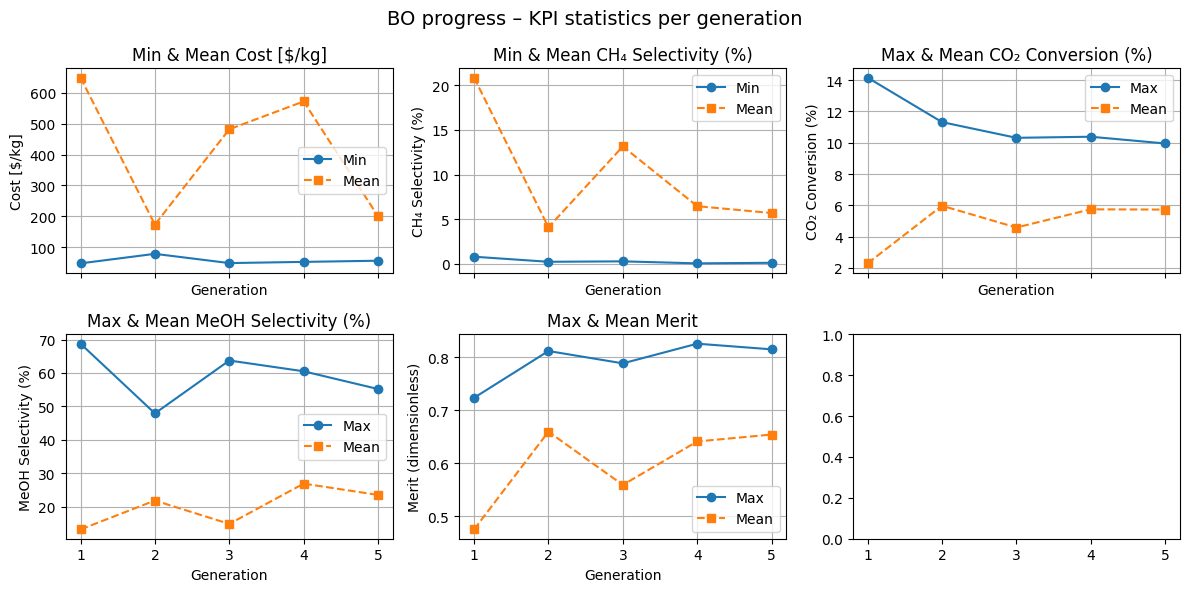

In [10]:
# ╔════════════════════════════════════════════════════════════════╗
# ║ KPI & Merit progress – best (max/min) and mean per generation ║
# ╚════════════════════════════════════════════════════════════════╝
import matplotlib.pyplot as plt
import numpy as np

nice_labels = {
    "cost" : "Cost [$/kg]",
    "ch4"  : "CH₄ Selectivity (%)",
    "co2"  : "CO₂ Conversion (%)",
    "meoh" : "MeOH Selectivity (%)",
}

# --- discover KPI columns ----------------------------------------
kpi_cols = {}
for col in bo.objective_cols:
    key = next((k for k in nice_labels if k in col.lower()), None)
    if key:
        kpi_cols[col] = nice_labels[key]
assert len(kpi_cols) == 4, f"KPI columns missing → {kpi_cols}"

# --- prepare 2×3 grid (drop spare slot) --------------------------
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True)
axs = axs.flatten()[:5]

# --- plot each KPI ----------------------------------------------
for ax, (col, label) in zip(axs, kpi_cols.items()):
    grp = bo.history.groupby("Generation")[col]
    is_minimise = any(k in col.lower() for k in ("cost", "ch4"))

    best = grp.min() if is_minimise else grp.max()
    avg  = grp.mean()

    ax.plot(best.index, best.values, marker="o",
            label=("Min" if is_minimise else "Max"))
    ax.plot(avg.index,  avg.values,  marker="s", ls="--",
            label="Mean")

    ax.set_ylabel(label)
    ax.set_title(f"{'Min' if is_minimise else 'Max'} & Mean {label}")
    ax.grid(True);  ax.legend()

# --- Merit subplot -----------------------------------------------
ax_merit = axs[-1]
merit_best = bo.history.groupby("Generation")["Merit"].max()
merit_mean = bo.history.groupby("Generation")["Merit"].mean()

ax_merit.plot(merit_best.index, merit_best.values, marker="o", label="Max")
ax_merit.plot(merit_mean.index, merit_mean.values, marker="s", ls="--", label="Mean")
ax_merit.set_ylabel("Merit (dimensionless)")
ax_merit.set_title("Max & Mean Merit"); ax_merit.grid(True); ax_merit.legend()

# --- cosmetics ----------------------------------------------------
for ax in axs:
    ax.set_xlabel("Generation")
fig.suptitle("BO progress – KPI statistics per generation", fontsize=14)
fig.tight_layout()
fig.savefig("bo_progress_kpi_grid.png", dpi=300)
plt.show()